## EDA

In [1]:
import pandas as pd
import numpy as np
import itertools
import copy
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.plotly as py
from plotly.graph_objs import *

## Read in tables

In the previous notebook, we pickled newly organized data so that we can later use it in any notebook. Now we will read them so we can use it in the dataframe

In [2]:
fifa_player_analysis = pd.read_pickle('fifa_player_analysis')
fifa_predict_position = pd.read_pickle('fifa_predict_position')

## Explore the data

Let's first explore the fifa_player_analysis data.

There are **15952 rows and 61 columns**
Each row consist of many Columns.

In [3]:
fifa_player_analysis.head()

,ID,league,Name,Club,Age,Nationality,Overall,Potential,Value,Wage,Preferred Positions,Position,numValue,numWage
0,20801,Spanish Primera División,Cristiano Ronaldo,Real Madrid CF,32,Portugal,94,94,€95.5M,€565K,ST LW,ST,95500000.0,565000.0
1,158023,Spanish Primera División,L. Messi,FC Barcelona,30,Argentina,93,93,€105M,€565K,RW,RW,105000000.0,565000.0
2,190871,French Ligue 1,Neymar,Paris Saint-Germain,25,Brazil,92,94,€123M,€280K,LW,LW,123000000.0,280000.0
3,176580,Spanish Primera División,L. Suárez,FC Barcelona,30,Uruguay,92,92,€97M,€510K,ST,ST,97000000.0,510000.0
4,167495,German Bundesliga,M. Neuer,FC Bayern Munich,31,Germany,92,92,€61M,€230K,GK,GK,61000000.0,230000.0


In [4]:
len(fifa_predict_position)

15742

Let's look at how top 25 players are shares same nationality by using a graph of NetworkX library.

We can see that Argentina has the most player in top 25 followed by **Belgium**, **Italy**, and **Spain**

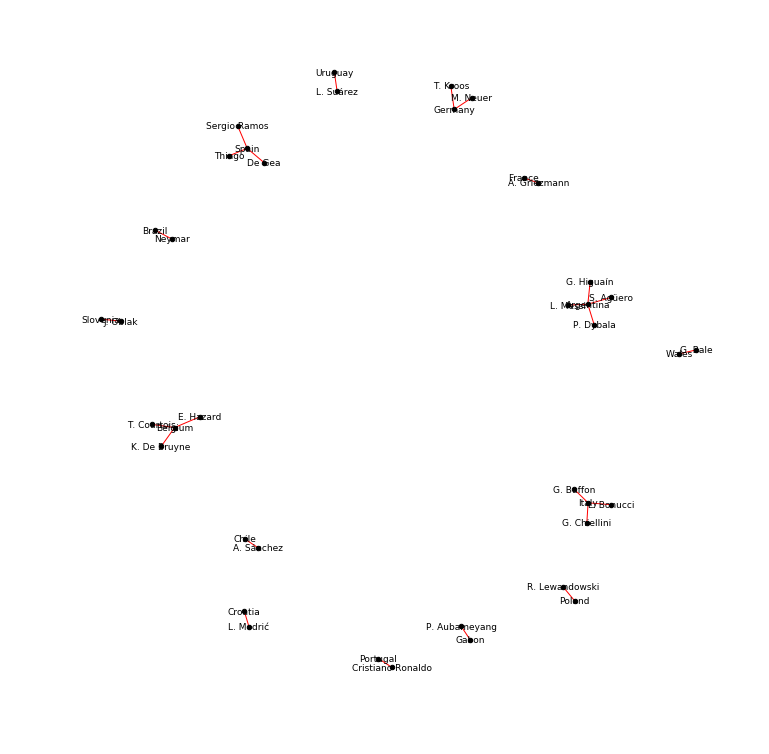

In [5]:
g = nx.OrderedGraph()

#adds edge in the graph. We add the edge between player's name and their nationality to see 
#in which country do Top 25 players come from
x=0;
for i, row in fifa_player_analysis.iterrows():
    if x == 25:
        break;
    g.add_edge(row[2], row[5], color='red')
    x += 1

plt.figure(figsize=(10, 10))

nx.draw(g, pos=nx.spring_layout(g), edge_color='red', node_size=20, node_color='black', with_labels=True, font_size=9)
plt.show()


For fun, let's look at how top players attributes are correlation bewteen age vs overall and potential.

In [6]:
## Get's Mean of overall of players age under than 39
fifa_by_age = fifa_player_analysis[fifa_player_analysis['Age'] <= 39].groupby('Age')['Overall'].mean()
fifa_by_age = fifa_by_age.to_frame()

## Get's Mean of potential of players age under than 39
fifa_potential = fifa_player_analysis[fifa_player_analysis['Age'] <= 39].groupby('Age')['Potential'].mean()



fifa_by_age = fifa_by_age.reset_index()
fifa_potential = fifa_potential.reset_index()


Overall = Scatter(
    x=fifa_by_age['Age'],
    y=fifa_by_age['Overall'],
    name='overall'
)
Potential = Bar(
    x=fifa_potential['Age'],
    y=fifa_potential['Potential'],
    name='potential'
)
data = [Overall, Potential]
py.iplot(data, filename='bar-line')

We see that when player is in his 30, they are performing their best in the game.

Now let's look at how many players are in each position.

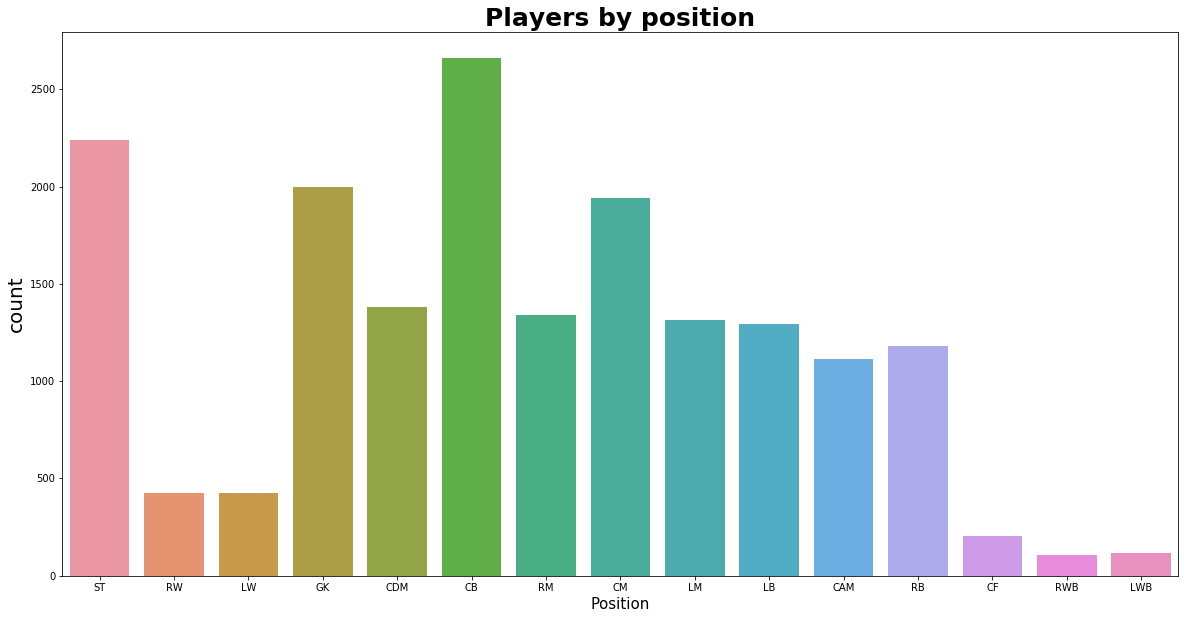

In [7]:
plt.figure(figsize=(20,10))
plt.title('Players by position', fontsize = 25, fontweight='bold')
plt.xlabel('Count', fontsize = 15)
plt.ylabel('Position', fontsize = 20)
sns.countplot(x='Position', data=fifa_player_analysis)
plt.show()

Looks like Center Back is the most popular position amont players, followed by Striker. 
I guess this is because there are more place for CB players to play, as for some formation, it requires multiple CB positions

## Data for Modeling

I want to see how the data looks life for position in attack, midfielder and defense.
I will be divide the position to be attack and defense in machine learning for simplification, but from the data, we clearly see there are certain characteristics for each position's attributes 

In [8]:
fifa_predict_position.head()

,ID,Aggression,Crossing,Curve,Dribbling,Finishing,Free kick accuracy,Heading accuracy,Long shots,Penalties,...,Agility,Reactions,Stamina,Balance,Ball control,Composure,Jumping,Sprint speed,Positioning,Preferred Positions
0,20801,63.0,85.0,81.0,91.0,94.0,76.0,88.0,92.0,85.0,...,89.0,96.0,92.0,63.0,93.0,95.0,95.0,91.0,95.0,ST
1,158023,48.0,77.0,89.0,97.0,95.0,90.0,71.0,88.0,74.0,...,90.0,95.0,73.0,95.0,95.0,96.0,68.0,87.0,93.0,RW
2,190871,56.0,75.0,81.0,96.0,89.0,84.0,62.0,77.0,81.0,...,96.0,88.0,78.0,82.0,95.0,92.0,61.0,90.0,90.0,LW
3,176580,78.0,77.0,86.0,86.0,94.0,84.0,77.0,86.0,85.0,...,86.0,93.0,89.0,60.0,91.0,83.0,69.0,77.0,92.0,ST
5,188545,80.0,62.0,77.0,85.0,91.0,84.0,85.0,83.0,81.0,...,78.0,91.0,79.0,80.0,89.0,87.0,84.0,83.0,91.0,ST


Let's look at all attributes of player distinguished by thier primary playing position

In [9]:
##Get's players in attack position for the future graph. We merge them by specific ID

fifa_attack = \
fifa_player_analysis[fifa_player_analysis['Position'].isin(['ST', 'RW', 'LW', 'CF'])].reset_index()
fifa_attack = fifa_attack[['ID', 'Name', 'Club', 'Overall', 'Position']]

fifa_attack_attr = pd.merge(fifa_attack, fifa_predict_position, how='inner', on='ID')

overall_attack = fifa_attack_attr.groupby(['Position']).mean()
overall_attack = overall_attack.drop(columns='ID')
overall_attack.head()


,Overall,Aggression,Crossing,Curve,Dribbling,Finishing,Free kick accuracy,Heading accuracy,Long shots,Penalties,...,Acceleration,Agility,Reactions,Stamina,Balance,Ball control,Composure,Jumping,Sprint speed,Positioning
Position,,,,,,,,,,,,,,,,,,,,,
CF,68.061453,49.743017,58.402235,59.759777,69.167598,64.206704,55.312849,55.865922,62.301676,62.871508,...,73.039106,72.653631,64.944134,64.458101,72.005587,68.614525,64.430168,63.055866,71.726257,65.396648
LW,67.594315,50.764858,61.395349,60.532300,70.129199,63.260982,52.604651,51.625323,60.175711,59.374677,...,77.291990,75.069767,62.196382,64.671835,73.049096,68.726098,62.472868,61.000000,76.795866,63.943152
RW,66.604113,48.640103,59.922879,57.766067,68.758355,62.303342,50.449871,51.624679,59.341902,58.544987,...,76.246787,73.778920,61.462725,64.388175,71.706941,67.575835,61.087404,59.956298,76.038560,63.179949
ST,66.611819,53.369333,48.125318,52.295976,63.804381,66.948039,45.763627,63.228732,60.013754,63.158431,...,69.139073,66.735099,62.673968,65.206317,64.015283,65.004075,61.484463,67.421803,70.056546,65.725420


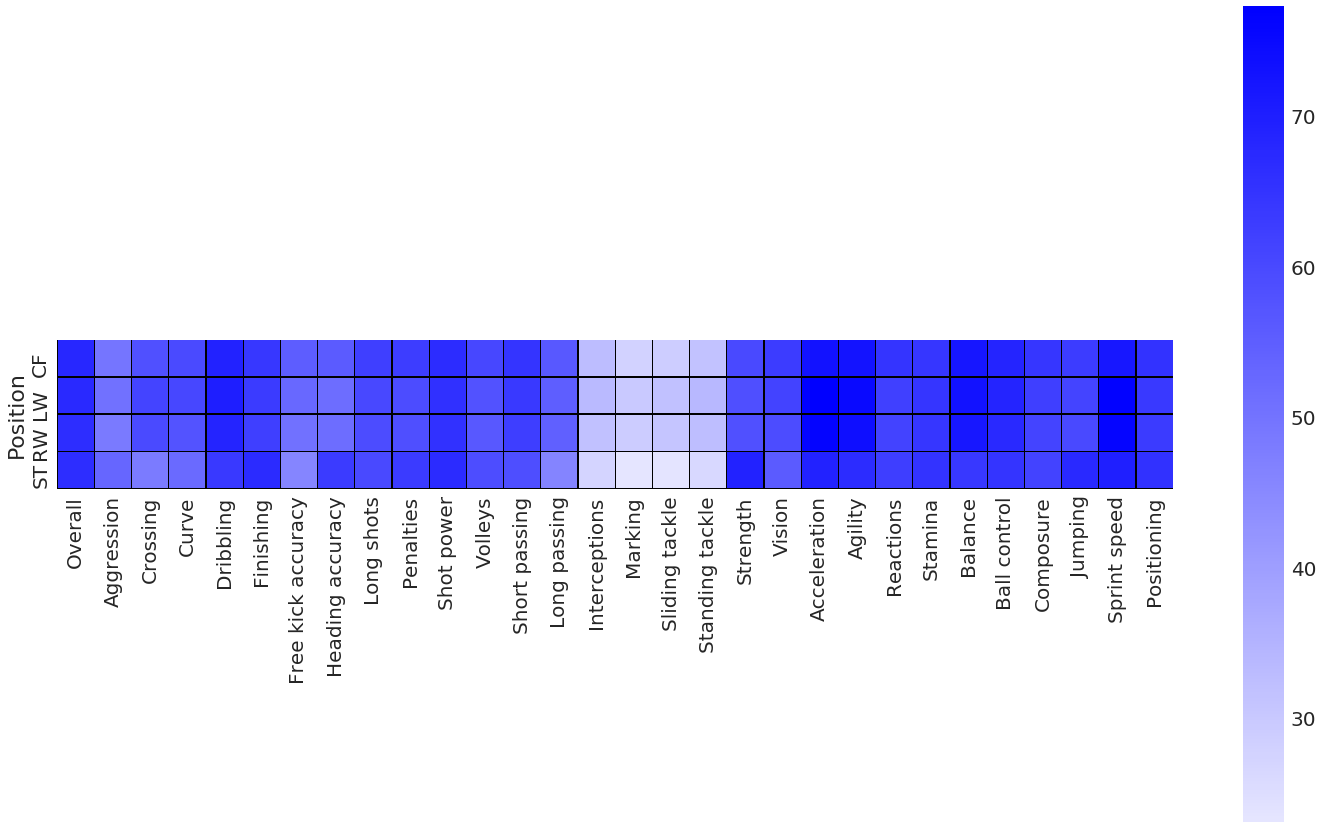

In [10]:
plt.figure(figsize=(25,15))

pal = sns.light_palette("blue", as_cmap=True)
sns.set(font_scale=2) 
sns.heatmap(overall_attack,
            xticklabels=overall_attack.columns.values,
            yticklabels=overall_attack.index.values,
           square = True,
           linecolor = 'black',
           linewidths=0.25,
           cmap = pal,
           annot = False)
plt.show()

We obviously see that attack position has very low defense attributes while shooting related attributes are excellent

In [11]:
fifa_mid = \
fifa_player_analysis[fifa_player_analysis['Position'].isin(['CDM', 'RM', 'CM', 'LM', 'CAM'])].reset_index()
fifa_mid = fifa_mid[['ID', 'Name', 'Club', 'Overall', 'Position']]

fifa_mid_attr = pd.merge(fifa_mid, fifa_predict_position, how='inner', on='ID')


overall_mid = fifa_mid_attr.groupby(['Position']).mean()
overall_mid = overall_mid.drop(columns='ID')

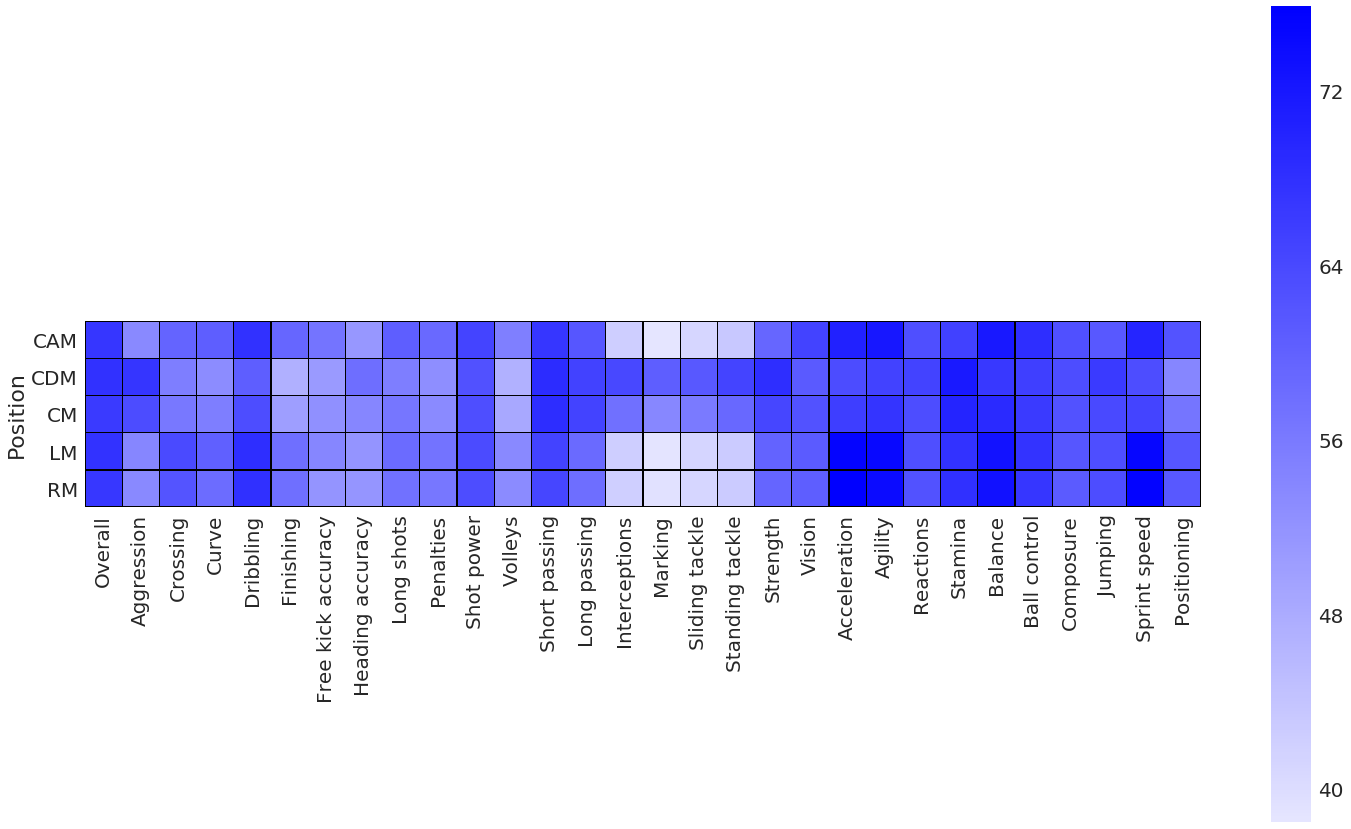

In [12]:
plt.figure(figsize=(25,15))

pal = sns.light_palette("blue", as_cmap=True)
sns.set(font_scale=2) 
sns.heatmap(overall_mid,
            xticklabels=overall_mid.columns.values,
            yticklabels=overall_mid.index.values,
           square = True,
           linecolor = 'black',
           linewidths=0.25,
           cmap = pal,
           annot = False)
plt.show()

In here, we see that for some position in midfielders, their defense attribution is higher than the others, as they participate in defense more than attack. But overall, we see that midfielders have strong pass ability as well as vision and balancing

In [13]:
fifa_def = \
fifa_player_analysis[fifa_player_analysis['Position'].isin(['CB', 'LB', 'RB', 'RWB', 'LWB'])].reset_index()
fifa_def = fifa_def[['ID', 'Name', 'Club', 'Overall', 'Position']]


fifa_def_attr = pd.merge(fifa_def, fifa_predict_position, how='inner', on='ID')


overall_def = fifa_def_attr.groupby(['Position']).mean()

overall_def.iloc[:, 14:18]
overall_def = overall_def.drop(columns='ID')

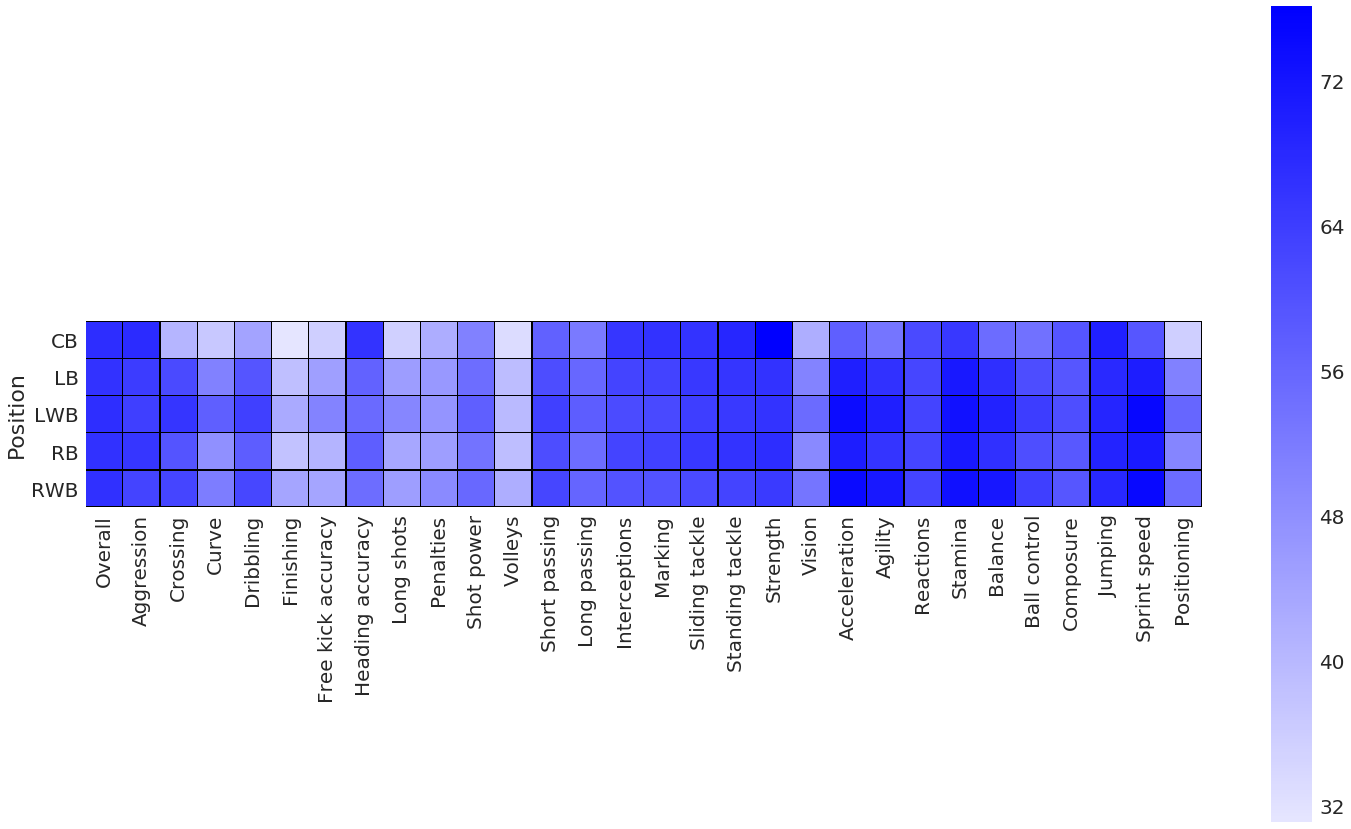

In [14]:
plt.figure(figsize=(25,15))

pal = sns.light_palette("blue", as_cmap=True)
sns.set(font_scale=2) 
sns.heatmap(overall_def,
            xticklabels=overall_def.columns.values,
            yticklabels=overall_def.index.values,
           square = True,
           linecolor = 'black',
           linewidths=0.25,
           cmap = pal,
           annot = False)
plt.show()

Finally, we see that defensive players' stats, and we can conclude that we will be able to distinguish defenseive players to others by looking at their defense statistics.

Lastly, let's explore the mean of each country's players value for top 500.

In [15]:
top_500 = fifa_player_analysis.sort_values("Overall", ascending=False).reset_index().head(500)[["Name", "Nationality", "league", "Overall", "Club", 'numValue']]

wageMean = lambda g: g.mean()/1000000

aggFunc = {'Name':['count'], 'Overall':['mean'], 'numValue': {'value' : wageMean}}

#top_500 = top_500.groupby(['Nationality']).agg(aggFunc)
top_500.head()

,Name,Nationality,league,Overall,Club,numValue
0,Cristiano Ronaldo,Portugal,Spanish Primera División,94,Real Madrid CF,95500000.0
1,L. Messi,Argentina,Spanish Primera División,93,FC Barcelona,105000000.0
2,Neymar,Brazil,French Ligue 1,92,Paris Saint-Germain,123000000.0
3,L. Suárez,Uruguay,Spanish Primera División,92,FC Barcelona,97000000.0
4,M. Neuer,Germany,German Bundesliga,92,FC Bayern Munich,61000000.0


In [16]:


plotly.tools.set_credentials_file(username='jhan0801', api_key='HTutQaf2twfeGaRq5yys')

playerCnt = [Bar(x=top_500.Nationality, y=top_500.numValue, marker=dict(color='#ffcdd2'))]

py.iplot(playerCnt, filename='basic_bar')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~jhan0801/0 or inside your plot.ly account where it is named 'basic_bar'
